### Libraries

In [1]:
import glob
import os
import pandas as pd

import numpy as np
from tqdm import tqdm

from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss

import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer

import warnings
warnings.filterwarnings("ignore")

___
### Выгрузка данных 

In [2]:
survey_fcasts = pd.DataFrame()

file_type = 'csv'
seperator =','

for f in glob.glob("*." + file_type):
    if f[:13] == 'survey_fcasts':
        data = pd.read_csv(f, sep=seperator, low_memory=False, encoding='ISO-8859-1')
        survey_fcasts = pd.concat([survey_fcasts, data])
    

ifps = pd.read_csv('ifps.csv', sep=seperator, encoding='ISO-8859-1')

In [3]:
survey_fcasts.head(5)

,ifp_id,ctt,cond,training,team,user_id,forecast_id,fcast_type,answer_option,value,fcast_date,expertise,q_status,viewtime,year,timestamp
0,1004-0,1a,1,a,NaN,600.0,-200987.0,0,a,0.10,2011-08-31,1.0,closed,NaN,1,2011-08-31 16:17:18
1,1004-0,1a,1,a,NaN,600.0,-200987.0,0,b,0.90,2011-08-31,1.0,closed,NaN,1,2011-08-31 16:17:18
2,1008-0,1a,1,a,NaN,600.0,-200986.0,0,a,0.25,2011-08-31,2.0,closed,NaN,1,2011-08-31 16:18:27
3,1008-0,1a,1,a,NaN,600.0,-200986.0,0,b,0.75,2011-08-31,2.0,closed,NaN,1,2011-08-31 16:18:27
4,1006-0,1a,1,a,NaN,600.0,-200985.0,0,a,0.10,2011-08-31,3.0,closed,NaN,1,2011-08-31 16:18:47


In [4]:
ifps.head(5)

,ifp_id,q_type,q_text,q_desc,q_status,date_start,date_suspend,date_to_close,date_closed,outcome,short_title,days_open,n_opts,options
0,1001-0,0,"Will the Six-Party talks (among the US, North ...",'In' refers to any time during the remainder o...,closed,9/1/11,12/30/11 0:00,12/31/11,1/2/12,b,Six-party talks resume,123.0,2,"(a) Yes, (b) No"
1,1002-0,0,Who will be inaugurated as President of Russia...,'In' refers to any time during the 2012 calend...,closed,9/1/11,5/14/12 0:00,5/15/12,5/6/12,b,president of Russia,248.0,3,"(a) Medvedev, (b) Putin, (c) Neither"
2,1003-0,0,Will Serbia be officially granted EU candidacy...,A 'yes' answer to this question requires not o...,closed,9/1/11,12/30/11 0:00,12/31/11,1/3/12,b,Serbia EU candidacy,124.0,2,"(a) Yes, (b) No"
3,1004-0,0,Will the United Nations General Assembly recog...,'By' means at or prior to the end of the day o...,closed,9/1/11,9/29/11 0:00,9/30/11,9/30/11,b,UN-GA recognize Palestine,29.0,2,"(a) Yes, (b) No"
4,1005-0,0,Will Daniel Ortega win another term as Preside...,If the Nicaraguan elections do not occur in la...,closed,9/1/11,11/4/11 0:00,11/5/11,11/5/11,a,Ortega win in Nicaragua,65.0,2,"(a) Yes, (b) No"


In [5]:
q_ifps = pd.DataFrame(ifps['q_text'].unique(), columns=['questions'])
unique_q_num = q_ifps.nunique()

# show some of them
(
q_ifps.questions[0], 
q_ifps.questions[391], 
q_ifps.questions[200] 
)

('Will the Six-Party talks (among the US, North Korea, South Korea, Russia, China, and Japan) formally resume in 2011?',
 'Will **national military force(s) from one or more countries *intervene in Syria **before 1 December 2014?',
 'When will Mariano Rajoy vacate the office of Prime Minister of Spain?')

In [6]:
f'Всего вопросов : {unique_q_num[0]}'

'Всего вопросов : 527'

___
### Предсказание людей в зависимости от их ответа в прошлый год

In [7]:
user_answers = survey_fcasts[['ifp_id','user_id','q_status','year','answer_option','timestamp','value','fcast_type','fcast_date']]
user_answers = user_answers[(~user_answers.user_id.isna()) & (user_answers.q_status == 'closed')].reset_index(drop=True)

user_answers['ans_type'] = user_answers.ifp_id.apply(lambda x: x[5:]).astype(int)
user_answers['question'] = user_answers.ifp_id.apply(lambda x: x[:4]).astype(int)

assert user_answers.user_id.apply(lambda x: x.is_integer()).sum() == user_answers.shape[0]

user_answers['user_id'] = user_answers['user_id'].astype(int)
user_answers = user_answers.sort_values(['question','user_id'])

In [8]:
user_answers.head(2)

,ifp_id,user_id,q_status,year,answer_option,timestamp,value,fcast_type,fcast_date,ans_type,question
5555,1001-0,3,closed,1,a,2011-09-06 05:46:12,0.5,1,2011-09-06,0,1001
5556,1001-0,3,closed,1,b,2011-09-06 05:46:12,0.5,1,2011-09-06,0,1001


In [9]:
mask = (ifps.q_status == 'closed') & (ifps.n_opts == 2) & (ifps.q_type == 0)
question_answers = ifps[mask][['ifp_id','outcome','date_closed']]
assert question_answers.ifp_id.nunique() == question_answers.shape[0]

In [10]:
question_answers.head(2)

,ifp_id,outcome,date_closed
0,1001-0,b,1/2/12
2,1003-0,b,1/3/12


### Creating final DataFrame

In [11]:
ans = question_answers.merge(user_answers, on='ifp_id', how='inner').drop(['q_status', 'ans_type', 'question'], axis=1)
ans.timestamp = ans.timestamp.astype('datetime64[ns]')
ans["outcome"] = (ans["outcome"] == "a").astype(int)
ans = ans.query('answer_option == "a"')

ans["date_closed"] = pd.to_datetime(ans["date_closed"]) + pd.Timedelta(days=1)
ans.dropna(subset=["user_id"], inplace = True)

ans["user_id"] = ans["user_id"].astype(int).astype(str)
ans["days_until_closure"] = (ans["date_closed"] - ans["timestamp"]).dt.days

master_data = ans.query("days_until_closure > 15").sort_values('fcast_date').groupby(['ifp_id', 'user_id']).tail(1)

In [12]:
model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')
sent_embeddings = model.encode(ifps.q_text)
embedding_df = pd.DataFrame(sent_embeddings)
embedding_df["ifp_id"] = ifps.ifp_id

In [13]:
event_outcomes = master_data.groupby("ifp_id").outcome.max().reset_index()
expert_inputs = master_data.pivot(index = "ifp_id", columns = "user_id", values = "value").fillna(0)
final_ans = pd.merge(pd.merge(expert_inputs, event_outcomes, on="ifp_id"), embedding_df, on="ifp_id")

In [14]:
final_ans.head()

,ifp_id,1000,10001,10010,10014,10016,10034,10043,10046,10049,...,758,759,760,761,762,763,764,765,766,767
0,1001-0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.012801,0.054331,-0.003304,0.056317,-0.032626,-0.003777,-0.126869,0.005910,-0.014981,0.071226
1,1003-0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.089883,0.073422,-0.009131,0.026745,0.032391,0.011453,-0.046191,0.044056,0.023257,0.072150
2,1004-0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.007930,0.043772,-0.006600,0.054891,-0.040151,0.024860,0.026045,0.057843,-0.017360,0.053682
3,1005-0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.009694,0.015173,-0.012122,-0.016311,-0.029741,-0.041757,-0.019839,0.061313,-0.008035,0.011067
4,1006-0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033361,0.051581,-0.093910,0.055607,0.062607,-0.011050,0.011645,-0.015175,0.009894,-0.036332


### Spliting dataframe on train and test

In [15]:
from sklearn.model_selection import train_test_split

In [78]:
X = final_ans.drop(['ifp_id', 'outcome'], axis=1)
y = final_ans['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Tuning hyperparameter 

In [103]:
bs = np.zeros(20)
different_C = np.geomspace(0.01, 5, 20)

for i in tqdm(range(len(different_C))):
    clf = LogisticRegression(penalty='l2', C=different_C[i]).fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)[:, 1]
    
    bs[i] = brier_score_loss(y_test, y_prob)
    
bs = list(bs)
different_C = list(different_C)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.16it/s]


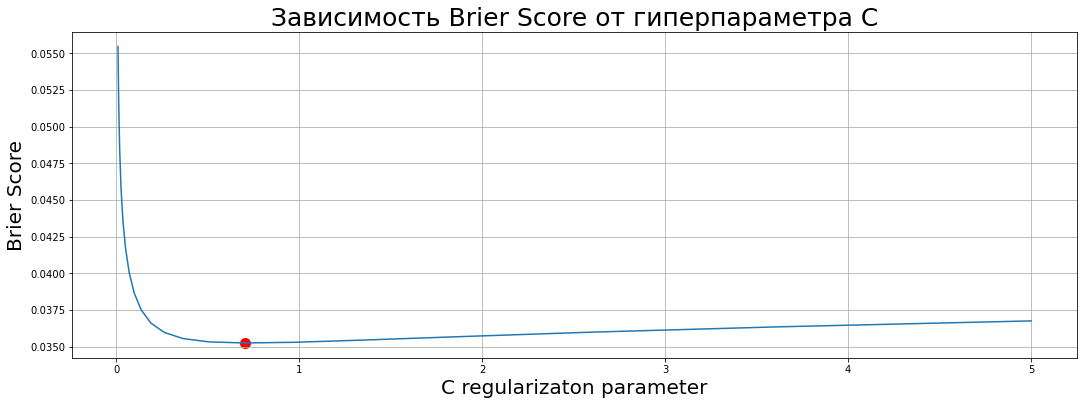

In [104]:
plt.figure(figsize=(18,6))

plt.title('Зависимость Brier Score от гиперпараметра C', fontsize=25)

plt.plot(different_C, bs)
plt.scatter(different_C[bs.index(min(bs))], min(bs), color='red', linewidths=5, alpha=1)

plt.xlabel('C regularizaton parameter', fontsize=20)
plt.ylabel('Brier Score', fontsize=20)
plt.grid()
plt.show()

In [106]:
print(f'Минимальное значение BS = {min(bs):.4f} при C = {different_C[bs.index(min(bs))]:.1f}')

simple_means = master_data.groupby("ifp_id").agg({"outcome": "mean", "value": "mean"})
print(f'Simple mean BS = {np.mean((simple_means["value"] - simple_means["outcome"])**2):.4f}')

Минимальное значение BS = 0.0352 при C = 0.7
Simple mean BS = 0.1099


## Кросс-валидация и grid-search (для стабильности)

In [82]:
from sklearn.model_selection import KFold, cross_val_score

In [83]:
from sklearn.model_selection import GridSearchCV

In [99]:
k_fold = KFold(n_splits=5)
parameters = {'C': np.geomspace(0.01, 5, 20)}

lr = LogisticRegression(penalty='l2', random_state=12)

clf = GridSearchCV(lr, parameters, cv=k_fold, scoring='neg_brier_score')

In [100]:
clf.fit(X_train, y_train)

clf.best_estimator_

LogisticRegression(C=0.3652259113562679, random_state=12)

In [101]:
y_prob = clf.predict_proba(X_test)[:, 1]

In [102]:
brier_score_loss(y_test, y_prob)

0.03554505333986127